In [1]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np

In [2]:
cross = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/county-cbsa-crosswalk-cleaned.csv')
cross = cross[['County Code','CBSA Code']]
cross.columns = ['FIPS', 'CBSA']
cross['FIPS'] = cross['FIPS'].astype(str).apply(lambda x: x.zfill(5))
cross['CBSA'] = cross['CBSA'].astype(str).apply(lambda x: x.zfill(5))

csob = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/county_state_of_birth.csv')
csob['FIPS'] = csob['FIPS'].astype(str).apply(lambda x: x.zfill(5))
csob = csob.merge(cross, on='FIPS', how='left')
csob = csob[~csob['CBSA'].isna()]
csob

FIPS             County    State  Population  Born in State   CBSA
0     01001     Autauga County  Alabama       55221          37418  33860
1     01003     Baldwin County  Alabama      195121         106414  19300
3     01007        Bibb County  Alabama       22604          18915  13820
4     01009      Blount County  Alabama       57710          46165  13820
7     01015     Calhoun County  Alabama      116648          84827  11500
...     ...                ...      ...         ...            ...    ...
3129  56025     Natrona County  Wyoming       80011          37346  16220
3133  56033    Sheridan County  Wyoming       29738          12019  43260
3135  56037  Sweetwater County  Wyoming       44772          18626  40540
3136  56039       Teton County  Wyoming       22311           5196  27220
3137  56041       Uinta County  Wyoming       20930           7295  21740

[1806 rows x 6 columns]

In [3]:
# Do we need to take in to account CBSAs that cross state lines?
# This block ouputs an integer. If > 0, there are Cross-state-line CBSAs in our dataset

cbsa_states = copy.deepcopy(csob)
cbsa_states['state code'] = cbsa_states['FIPS'].astype(str).apply(lambda x: x[0:2])
cbsa_states = cbsa_states[['CBSA','state code']]
cbsa_states = cbsa_states.drop_duplicates()
counts = cbsa_states['CBSA'].value_counts()
cbsa_states['count'] = cbsa_states['CBSA'].apply(lambda x: counts[x])
cbsa_states = cbsa_states[cbsa_states['count']>1]
cbsa_states = cbsa_states[['CBSA','state code']]
len(cbsa_states['CBSA'].unique())

62

In [4]:
# Ignoring that effect for now
cbsa_sob = csob.groupby('CBSA').sum()
cbsa_sob['native'] = cbsa_sob['Born in State'] / cbsa_sob['Population']
cbsa_sob = cbsa_sob.reset_index()
cbsa_sob = cbsa_sob[['CBSA','native']]
cbsa_sob

CBSA    native
0    10100  0.711464
1    10140  0.639662
2    10180  0.702361
3    10220  0.707975
4    10300  0.743706
..     ...       ...
912  49660  0.778492
913  49700  0.623859
914  49740  0.351584
915  49780  0.860665
916  49820  0.644954

[917 rows x 2 columns]

In [5]:
cbsa_data = pd.read_csv('/Users/jericho/Documents/csi/csi-research/Data/clean/cbsa/cbsa_summary.csv')
cbsa_data['GTCBSA'] = cbsa_data['GTCBSA'].astype(str).apply(lambda x: x.zfill(5))
print(cbsa_data.columns)
cbsa_logpop = cbsa_data[['GTCBSA','LOG_POP']]
cbsa_data = cbsa_data[['GTCBSA','POP','AVG_NHFAMILY_TIME', 'AVG_NHFAMILY_IX', 'AVG_FRIEND_TIME',
                        'AVG_CCC_TIME', 'AVG_NHSOCIAL_TIME', 'AVG_NHFAMILY_SOCIAL_TIME_RATIO',]]
cbsa_data.columns = ['CBSA'] + cbsa_data.columns.tolist()[1:]
cbsa_data = cbsa_data.merge(cbsa_sob,on='CBSA',how='left')
cbsa_data

Index(['GTCBSA', 'NAME', 'ALAND', 'SQRT_ALAND', 'POP', 'LOG_POP', 'POP_DEN',
       'L_POPDEN', 'POP15', 'L_POP15DEN', 'LOG_POP15', 'POP15_DEN',
       'TUFINLWGT', 'AVG_FAMILY_TIME', 'AVG_FAMILY_IX', 'AVG_HHFAMILY_TIME',
       'AVG_HHFAMILY_IX', 'AVG_NHFAMILY_TIME', 'AVG_NHFAMILY_IX',
       'AVG_FRIEND_TIME', 'AVG_FRIEND_IX', 'AVG_CCC_TIME', 'AVG_CCC_IX',
       'AVG_NHSOCIAL_TIME', 'AVG_NHFAMILY_SOCIAL_TIME_RATIO',
       'AVG_TRIP_TO_NHFAMILY_DUR', 'RESP_COUNT'],
      dtype='object')


CBSA     POP  AVG_NHFAMILY_TIME  AVG_NHFAMILY_IX  AVG_FRIEND_TIME  \
0    10180  170669              58.83             0.49            20.45   
1    10420  703845             132.62             0.35            59.74   
2    10580  880736              86.47             0.30            19.95   
3    10740  912108              70.16             0.34            18.69   
4    10900  837610              57.36             0.28            45.00   
..     ...     ...                ...              ...              ...   
253  49180  666216              98.70             0.42            48.13   
254  49340  941338             115.21             0.47            37.56   
255  49620  445565             153.14             0.52            19.77   
256  49660  541846              98.52             0.45            22.81   
257  49740  209468             129.68             0.45            37.54   

     AVG_CCC_TIME  AVG_NHSOCIAL_TIME  AVG_NHFAMILY_SOCIAL_TIME_RATIO    native  
0          313.49             392.77                            0.19  0.702361  
1          128.45             320.81                            0.26  0.767698  
2           97.45             203.88                            0.24  0.771225  
3          161.69             250.54                            0.24  0.529291  
4          127.61             229.97                            0.18  0.626751  
..            ...                ...                             ...       ...  
253         67.35             214.19                            0.34  0.645179  
254        193.38             346.15                            0.29  0.668222  
255        157.99             330.91                            0.41  0.661893  
256        101.95             223.27                            0.32  0.778492  
257         90.20             257.42                            0.38  0.351584  

[258 rows x 9 columns]

In [27]:
cbsa_data.to_csv('percent_native.csv')

In [6]:
#cbsa_data['native'] = cbsa_data['native'].apply(lambda x: 1-x)

SpearmanrResult(correlation=0.022089950532927696, pvalue=0.723985493887295)


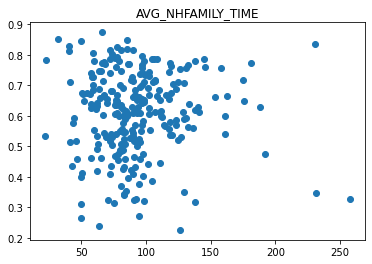

SpearmanrResult(correlation=0.13741812457613894, pvalue=0.02731234794190791)


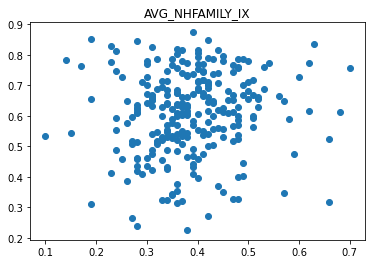

SpearmanrResult(correlation=-0.038258252550676, pvalue=0.5406975014377162)


SpearmanrResult(correlation=0.0720328249963577, pvalue=0.2489520410744644)


SpearmanrResult(correlation=0.0904633923291849, pvalue=0.14734483765991419)


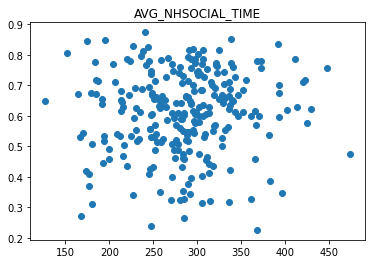

SpearmanrResult(correlation=0.12376075347769666, pvalue=0.04704661883474073)


In [7]:
for col in cbsa_data.columns.tolist()[2:-1]:
    plt.scatter(cbsa_data[col],cbsa_data['native'])
    plt.title(col)
    rho = stats.spearmanr(cbsa_data[col],cbsa_data['native'])
    print(rho)
    plt.show()

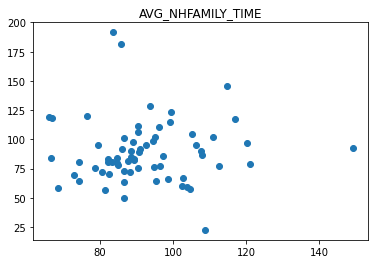

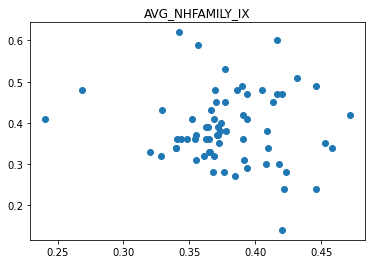

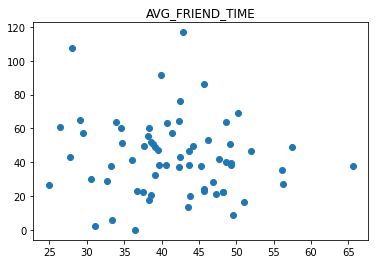

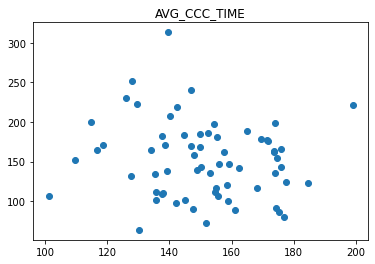

In [8]:
cbsa_data.columns
rands = np.random.random(size=len(cbsa_data))
cbsa_data['rand'] = rands
RFR = RandomForestRegressor(max_depth=10, random_state=0)

for col in cbsa_data.columns.tolist()[2:-2]:
    X = cbsa_data[['POP','native','rand']]
    y = cbsa_data[[col, 'rand']]
    X_train,X_test = X[X['rand'] > 0.3] , X[X['rand'] <= 0.3]
    y_train,y_test = y[y['rand'] > 0.3] , y[y['rand'] <= 0.3]
    X_train,X_test = X_train[['POP','native']] , X_test[['POP','native']]
    y_train,y_test = y_train[col].tolist() , y_test[col].tolist()
    RFR.fit(X_train, y_train)
    y_pred = RFR.predict(X_test)
    plt.scatter(y_pred,y_test)
    plt.title(col)
    plt.show()



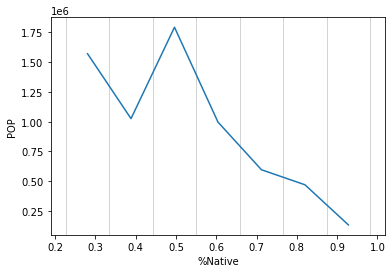

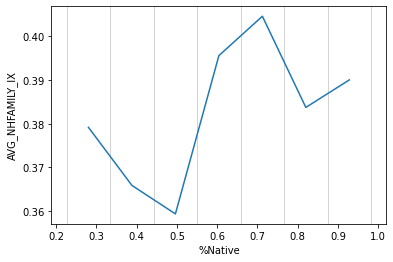

In [9]:
def bin_equal(array,bins):
    amin,amax = min(array),max(array)
    step = (amax-amin)/bins
    bins = [(i-amin)//step for i in array]
    mbin = max(bins)
    bin_partitions = [amin+step*i for i in range(int(mbin)+2)]
    return bins, bin_partitions

bins, partitions = bin_equal(cbsa_data['native'].tolist(), 6)
cbsa_data['native_bins'] = bins
partition_mids = [(partitions[i]+partitions[i+1])/2 for i in range(len(partitions)-1)]

cbsa_binned = copy.deepcopy(cbsa_data)
cbsa_binned.index = cbsa_binned['CBSA']
cbsa_binned = cbsa_binned[cbsa_binned.columns.tolist()[1:-3]+['native_bins']]
cbsa_binned = cbsa_binned.groupby('native_bins').mean()
cbsa_binned

for col in ['POP', 'AVG_NHFAMILY_TIME', 'AVG_NHFAMILY_IX', 'AVG_FRIEND_TIME', 'AVG_CCC_TIME', 'AVG_NHSOCIAL_TIME', 'AVG_NHFAMILY_SOCIAL_TIME_RATIO']:
    for i in partitions:
        plt.axvline(x=i,linewidth=0.5,c='darkgrey')
    plt.plot(partition_mids,cbsa_binned[col])
    plt.ylabel(col)
    plt.xlabel('%Native')
    plt.show()


In [10]:
loc = '/Users/jericho/Documents/csi/csi-research/Data/fb_data/'
fb_df = pd.read_csv(loc+'usa_data_narrow.csv')
fb_df.polygon_id = fb_df.polygon_id.astype(str).apply(lambda x: x.zfill(5))
fb_df.ds = fb_df.ds.astype(str).apply(lambda x: x.zfill(10))
fb_df.columns = ['FIPS']+fb_df.columns.tolist()[1:]

fb_df = fb_df.merge(csob, on='FIPS', how='left')
fb_df = fb_df[~fb_df['CBSA'].isna()]
fb_df = fb_df[fb_df['CBSA'].isin(cbsa_data['CBSA'].tolist())]
fb_df['moved_percent'] = 1-fb_df['all_day_ratio_single_tile_users'] 
fb_df['moved_pop_percent'] = fb_df['Population']*fb_df['moved_percent']
fb_df['relative_pop_percent'] = fb_df['Population']*fb_df['all_day_bing_tiles_visited_relative_change']
fb_df['cbsa_date'] = fb_df['CBSA']+fb_df['ds']
fb_df.head()

FIPS          ds  all_day_bing_tiles_visited_relative_change  \
0  01001  2020-03-01                                     0.04845   
1  01001  2020-03-02                                     0.03275   
2  01001  2020-03-03                                     0.05122   
3  01001  2020-03-04                                    -0.04741   
4  01001  2020-03-05                                     0.06285   

   all_day_ratio_single_tile_users          County    State  Population  \
0                          0.18910  Autauga County  Alabama     55221.0   
1                          0.15003  Autauga County  Alabama     55221.0   
2                          0.14391  Autauga County  Alabama     55221.0   
3                          0.16058  Autauga County  Alabama     55221.0   
4                          0.15298  Autauga County  Alabama     55221.0   

   Born in State   CBSA  moved_percent  moved_pop_percent  \
0        37418.0  33860        0.81090        44778.70890   
1        37418.0  33860        0.84997        46936.19337   
2        37418.0  33860        0.85609        47274.14589   
3        37418.0  33860        0.83942        46353.61182   
4        37418.0  33860        0.84702        46773.29142   

   relative_pop_percent        cbsa_date  
0            2675.45745  338602020-03-01  
1            1808.48775  338602020-03-02  
2            2828.41962  338602020-03-03  
3           -2618.02761  338602020-03-04  
4            3470.63985  338602020-03-05

In [11]:
fb_cbsa = fb_df.groupby('cbsa_date').sum()
fb_cbsa['moved_percent'] = fb_cbsa['moved_pop_percent']/fb_cbsa['Population']
fb_cbsa['relative_change'] = fb_cbsa['relative_pop_percent']/fb_cbsa['Population']
fb_cbsa = fb_cbsa.reset_index()
fb_cbsa['CBSA'] = fb_cbsa['cbsa_date'].apply(lambda x: x[:5])
fb_cbsa['ds'] = fb_cbsa['cbsa_date'].apply(lambda x: x[5:])
fb_cbsa = fb_cbsa[['CBSA','ds','moved_percent','relative_change']]

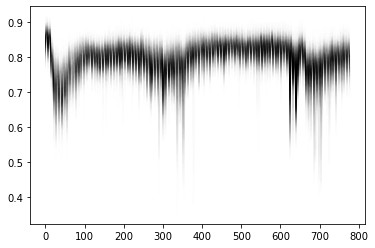

In [12]:
for cbsa in fb_cbsa['CBSA'].unique():
    temp_df = fb_cbsa[fb_cbsa['CBSA']==cbsa]
    temp_array = temp_df['moved_percent'].tolist()
    plt.plot(temp_array,c='black',alpha=0.005)

In [13]:
for cbsa in fb_cbsa['CBSA'].unique():
    temp_df = fb_cbsa[fb_cbsa['CBSA']==cbsa]
    temp_array = temp_df['relative_change'].tolist()
    plt.plot(temp_array,c='black',alpha=0.1)
plt.xlim(40,50)

(40.0, 50.0)

In [14]:
fb_cbsa

CBSA          ds  moved_percent  relative_change
0       10180  2020-03-01       0.829823         0.124324
1       10180  2020-03-02       0.875885         0.039011
2       10180  2020-03-03       0.884361         0.064730
3       10180  2020-03-04       0.850803        -0.037238
4       10180  2020-03-05       0.882613         0.038580
...       ...         ...            ...              ...
200719  49740  2022-04-13       0.832410        -0.049480
200720  49740  2022-04-14       0.824920        -0.060740
200721  49740  2022-04-15       0.809250        -0.117710
200722  49740  2022-04-16       0.805310        -0.126780
200723  49740  2022-04-17       0.769150        -0.053830

[200724 rows x 4 columns]

In [15]:
#cbsa_logpop
cbsa_logpop.columns = ['CBSA','LOG_POP']

In [16]:
bins, partitions = bin_equal(cbsa_logpop['LOG_POP'].tolist(), 6)
cbsa_logpop['popbins'] = [int(i) for i in bins]

fb_binned = fb_cbsa.merge(cbsa_logpop,how='left',on='CBSA')
fb_binned['moved_percent'].min()
fb_binned['moved_percent'].max()

0.9175700000000001

In [17]:
def mean_iqr(array):
    mu = sum(array)/len(array)
    lqr = sorted(array)[int(len(array)*0.25)]
    median = sorted(array)[int(len(array)*0.5)]
    uqr = sorted(array)[int(len(array)*0.75)]
    return mu, lqr, median, uqr

def plot_binned(df,partitions,plot_col,bin_col,title):
    bin_vals = sorted(list(set(df[bin_col].tolist())))
    mus, lqrs, meds, uqrs = [],[],[],[]
    for bin in bin_vals:
        temp_df = df[df[bin_col]==bin]
        vals = temp_df[plot_col].tolist()
        mu,lqr,med,uqr = mean_iqr(vals)
        mus.append(mu)
        lqrs.append(lqr)
        meds.append(med)
        uqrs.append(uqr)
    x = [(partitions[i]+partitions[i+1])/2 for i in range(len(partitions)-1)]
    plt.plot(x,meds,c='darkslategrey')
    plt.scatter(x,mus,marker='x',c='darkslategrey')
    for i in range(len(x)):
        plt.plot([x[i],x[i]], [lqrs[i],uqrs[i]],c='darkslategrey',linewidth=3)
    plt.ylim((0.5,0.9))
    plt.title(title)


#plot_binned(temp_df, partitions, 'moved_percent','popbins','')

In [18]:
days = sorted(list(set(fb_binned['ds'].tolist())))

for day in days:
    temp_df = fb_binned[fb_binned['ds']==day]
    plot_binned(temp_df, partitions, 'moved_percent','popbins',day)
    plt.savefig('/Users/jericho/Documents/csi/csi-research/plots/movement/'+day+'.jpg')
    plt.clf()
    #plt.show()


<Figure size 432x288 with 0 Axes>

In [19]:
fb_binned
fb_binned['month'] = fb_binned['ds'].astype(str).apply(lambda x: x[:7])
fb_binned['cbsa_month'] = fb_binned['CBSA'] + fb_binned['month']
fb_month_binned = fb_binned.groupby('cbsa_month').mean()
fb_month_binned = fb_month_binned.reset_index()
fb_month_binned['CBSA'] = fb_month_binned['cbsa_month'].apply(lambda x: x[:5])
fb_month_binned['month'] = fb_month_binned['cbsa_month'].apply(lambda x: x[5:])
fb_month_binned = fb_month_binned[['CBSA', 'month', 'moved_percent', 'relative_change', 'LOG_POP', 'popbins']]
fb_month_binned

CBSA    month  moved_percent  relative_change  LOG_POP  popbins
0     10180  2020-03       0.823773        -0.070509     5.23      0.0
1     10180  2020-04       0.772453        -0.211157     5.23      0.0
2     10180  2020-05       0.814462        -0.086111     5.23      0.0
3     10180  2020-06       0.832633        -0.025926     5.23      0.0
4     10180  2020-07       0.817468        -0.067746     5.23      0.0
...     ...      ...            ...              ...      ...      ...
6703  49740  2021-12       0.810859        -0.030879     5.32      0.0
6704  49740  2022-01       0.788745        -0.092572     5.32      0.0
6705  49740  2022-02       0.803941        -0.047801     5.32      0.0
6706  49740  2022-03       0.812958        -0.023004     5.32      0.0
6707  49740  2022-04       0.815028        -0.041132     5.32      0.0

[6708 rows x 6 columns]

In [20]:
def cmap_to_list(array):
    cmap = cm.get_cmap('plasma')
    minv,maxv = min(array),max(array)
    normalized = [(i-minv)/(maxv-minv) for i in array]
    colors = [cmap(i) for i in normalized]
    return colors

fb_month_data = fb_month_binned.merge(cbsa_data,how='left',on='CBSA')
bin_colors = cmap_to_list(fb_month_data['popbins'])

In [21]:
fb_month_data

CBSA    month  moved_percent  relative_change  LOG_POP  popbins  \
0     10180  2020-03       0.823773        -0.070509     5.23      0.0   
1     10180  2020-04       0.772453        -0.211157     5.23      0.0   
2     10180  2020-05       0.814462        -0.086111     5.23      0.0   
3     10180  2020-06       0.832633        -0.025926     5.23      0.0   
4     10180  2020-07       0.817468        -0.067746     5.23      0.0   
...     ...      ...            ...              ...      ...      ...   
6703  49740  2021-12       0.810859        -0.030879     5.32      0.0   
6704  49740  2022-01       0.788745        -0.092572     5.32      0.0   
6705  49740  2022-02       0.803941        -0.047801     5.32      0.0   
6706  49740  2022-03       0.812958        -0.023004     5.32      0.0   
6707  49740  2022-04       0.815028        -0.041132     5.32      0.0   

         POP  AVG_NHFAMILY_TIME  AVG_NHFAMILY_IX  AVG_FRIEND_TIME  \
0     170669              58.83             0.49            20.45   
1     170669              58.83             0.49            20.45   
2     170669              58.83             0.49            20.45   
3     170669              58.83             0.49            20.45   
4     170669              58.83             0.49            20.45   
...      ...                ...              ...              ...   
6703  209468             129.68             0.45            37.54   
6704  209468             129.68             0.45            37.54   
6705  209468             129.68             0.45            37.54   
6706  209468             129.68             0.45            37.54   
6707  209468             129.68             0.45            37.54   

      AVG_CCC_TIME  AVG_NHSOCIAL_TIME  AVG_NHFAMILY_SOCIAL_TIME_RATIO  \
0           313.49             392.77                            0.19   
1           313.49             392.77                            0.19   
2           313.49             392.77                            0.19   
3           313.49             392.77                            0.19   
4           313.49             392.77                            0.19   
...            ...                ...                             ...   
6703         90.20             257.42                            0.38   
6704         90.20             257.42                            0.38   
6705         90.20             257.42                            0.38   
6706         90.20             257.42                            0.38   
6707         90.20             257.42                            0.38   

        native      rand  native_bins  
0     0.702361  0.138239          4.0  
1     0.702361  0.138239          4.0  
2     0.702361  0.138239          4.0  
3     0.702361  0.138239          4.0  
4     0.702361  0.138239          4.0  
...        ...       ...          ...  
6703  0.351584  0.325578          1.0  
6704  0.351584  0.325578          1.0  
6705  0.351584  0.325578          1.0  
6706  0.351584  0.325578          1.0  
6707  0.351584  0.325578          1.0  

[6708 rows x 16 columns]

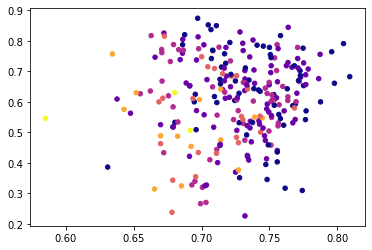

In [22]:
#for month in fb_month_data['month'].unique():
df = fb_month_data[fb_month_data['month']=='2020-04']
bin_colors = cmap_to_list(df['popbins'])
plt.scatter(df['moved_percent'],df['native'],c=bin_colors,s=20)
#plt.title(month)
plt.show()

In [23]:
X = df[['LOG_POP','AVG_NHFAMILY_TIME', 'AVG_NHFAMILY_IX',
       'AVG_FRIEND_TIME', 'AVG_CCC_TIME', 'AVG_NHSOCIAL_TIME',
       'AVG_NHFAMILY_SOCIAL_TIME_RATIO', 'native']]
y = df['moved_percent'].tolist()

X = StandardScaler().fit_transform(X)

reg = LinearRegression().fit(X, y)
reg.coef_.tolist()

[-0.013700475886463963,
 -2.9577848111251868,
 -0.0008462251385962238,
 -1.9799506142882755,
 -4.340965574200011,
 5.27808162921455,
 0.0009893174140900296,
 -0.00040893710746181533]

In [24]:
X = df[['LOG_POP', 'AVG_FRIEND_TIME', 'AVG_CCC_TIME','AVG_NHSOCIAL_TIME','native','moved_percent']]
y = df['AVG_NHFAMILY_IX'].tolist()

X = StandardScaler().fit_transform(X)

reg = LinearRegression().fit(X, y)
print(reg.score(X,y))
reg.coef_.tolist()

0.4462195260616182


[-0.0071032522585122645,
 -0.04149999069184174,
 -0.090611376239686,
 0.11092343462174233,
 0.007956809604285957,
 -0.00012405572792427433]

In [25]:
X = df[['LOG_POP','AVG_NHFAMILY_TIME', 'AVG_NHFAMILY_IX',
       'AVG_FRIEND_TIME', 'AVG_CCC_TIME', 'AVG_NHSOCIAL_TIME',
       'AVG_NHFAMILY_SOCIAL_TIME_RATIO', 'native']]
y = df['moved_percent'].tolist()

RFR = RandomForestRegressor(max_depth=10, random_state=0)

RFR.fit(X,y)
print(RFR.score(X,y))
RFR.feature_importances_

0.8225161726306996


array([0.30550124, 0.08332754, 0.0766075 , 0.13888703, 0.07843481,
       0.07856561, 0.07115887, 0.16751739])

In [26]:
features = ['LOG_POP','AVG_NHFAMILY_TIME', 'AVG_NHFAMILY_IX',
       'AVG_FRIEND_TIME', 'AVG_CCC_TIME','AVG_NHSOCIAL_TIME', 
       'AVG_NHFAMILY_SOCIAL_TIME_RATIO']
X = df[features]

X = StandardScaler().fit_transform(X)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

for i in ['moved_percent', 'native']:
    y = np.array(df[i].tolist())

    R2_vals = []
    feature_importance = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        RFR = RandomForestRegressor(max_depth=2)#, random_state=42)
        RFR.fit(X_train,y_train)
        R2_vals.append(RFR.score(X_test,y_test))
        feature_importance.append(RFR.feature_importances_)
    
    print(i)
    print(sum(R2_vals)/len(R2_vals))
    print(R2_vals)
    print(feature_importance)


    



moved_percent
0.07831983751147491
[-0.018628132362206395, 0.098949092592018, -0.057279474731755764, 0.19763001320584295, 0.17092768885347576]
[array([0.80445289, 0.02082667, 0.01841649, 0.10521159, 0.03390024,
       0.00672688, 0.01046524]), array([0.74499811, 0.04943265, 0.02761605, 0.10806537, 0.04074148,
       0.01533939, 0.01380696]), array([0.74711519, 0.01035654, 0.0278153 , 0.16356849, 0.01448563,
       0.01758116, 0.0190777 ]), array([0.61053415, 0.04594996, 0.02300197, 0.11716235, 0.08833204,
       0.06593287, 0.04908666]), array([0.70570685, 0.03701841, 0.03576663, 0.13987373, 0.03447372,
       0.03228667, 0.01487399])]
native
-0.022423273966531897
[-0.03832350635022297, -0.08010764436321116, 0.00928780721104383, -0.012885739178152056, 0.009912712847882865]
[array([0.30446622, 0.19758061, 0.09739507, 0.04791172, 0.15752405,
       0.09383012, 0.10129222]), array([0.46222644, 0.1792607 , 0.06527521, 0.03595919, 0.13425723,
       0.09511628, 0.02790495]), array([0.3419699